In [1]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../data/'
ARTIFACTS_FOLDER='../data/artifacts'


In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
#Disabled for numpy and opencv: avod has opencv and numpy versions for several methods
from multiprocessing import Pool

import os
#os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import cv2
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import argparse
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R
import io
from typing import Tuple, List

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix


In [3]:
gpus = tf.compat.v1.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1) 
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

1 Physical GPUs, 1 Logical GPU
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 850M, pci bus id: 0000:0a:00.0, compute capability: 5.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [4]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 13.4 seconds.
Reverse indexing ...
Done reverse indexing in 4.3 seconds.


In [5]:
import utils.anchor_helper
from utils.frame_helper import FrameCalibrationData
import utils.frame_helper as frame_helper
import utils.preproc_helper as preproc_helper
import utils.bev_helper as bev_helper
import utils.rpn_helper as rpn_helper
import utils.rpn_keras as rpn_keras

In [6]:
from PIL import Image

In [7]:
# Network input data: loop to get batch info
dataset=level5data

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))

img_input_list=[]
img_target=[]
bev_input_list=[]
ground_plane_list=[]
lidar=[]
boxes_c=[]
boxes_b=[]
class_list=[]
cam_path_list=[]
bev_path_list=[]

my_scene = dataset.scene[0]

        
voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
#arbitrary shape, must be square though!
bev_shape = (336,336, 3)
        
# Only handle one sample at a time for now
my_sample_token = my_scene["first_sample_token"]
my_last_sample_token = my_scene["last_sample_token"]
sample = dataset.get('sample', my_sample_token)
tok=sample['data']["CAM_FRONT"]
tok_bev=sample['data']["LIDAR_TOP"]
iboxes=dataset.get_boxes(tok)   
bboxes=dataset.get_boxes(tok_bev)
data_path, boxes, camera_intrinsic = dataset.get_sample_data(
                tok_bev)
data_path, uboxes, camera_intrinsic = dataset.get_sample_data(
                tok)

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))
print(iboxes[0], boxes[0].center/4)
#anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(tok, classes, dataset)
i=0
with tf.device('/GPU:0'):
    while my_sample_token!=my_last_sample_token:
        
        clss=[]
        
        sample = dataset.get('sample', my_sample_token)
        sample_name = sample.get("token")
        img_data = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        camera_token=img_data.get("token")

        tok=sample['data']["CAM_FRONT"]
        ego_pose = dataset.get("ego_pose", img_data["ego_pose_token"])
        cam_path, boxes_cam, camera_intrinsic = dataset.get_sample_data(camera_token)
        cam_path_list.append(cam_path)
        data = Image.open(cam_path)
        boxes_c.append(np.asarray(boxes_cam))
        for t in boxes_cam:
            clss.append(t.name)
        class_list.append(clss)
        #anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(sample_name, classes, dataset)
        #print(label_boxes_3d.shape)
        bev_input = dataset.get('sample_data', sample['data']["LIDAR_TOP"])
        bev_data = bev_input
        bev_token= bev_input.get("token")
        lidar_data = dataset.get("sample_data", bev_token)
        lidar_filepath = dataset.get_sample_data_path(bev_token)
        bev_path_list.append(lidar_filepath)
        ego_pose = dataset.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor_lidar = dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
        global_from_car = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
        car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                                  inverse=False)
        lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
        lidar_pointcloud.transform(car_from_sensor_lidar)
        lidar.append(lidar_pointcloud.points)
        x=sample["data"]["LIDAR_TOP"]
        lidar_path, boxes_bev, _ = dataset.get_sample_data(x)
        bev_helper.move_boxes_to_car_space(boxes_bev, ego_pose)
        bev_helper.scale_boxes(boxes_bev, 0.8)
        boxes_b.append(boxes_bev)
        bev = bev_helper.create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        #ego_centric_map = bev_helper.get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
        bev_array = bev_helper.normalize_voxel_intensities(bev)
        bev_input_list.append(bev_array)

        file_name=dataset.get_sample_data_path(camera_token)
        image1 = Image.open(file_name)
        # compress image, it is too big
        # convert image to numpy array
        image = image1.resize((358,300), Image.ANTIALIAS)
        img_array = np.asarray(image)
        img_input_list.append(img_array)

        cam_front_token = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        cam_front_data = cam_front_token.get("calibrated_sensor_token")
        cam_front_calib = dataset.get("calibrated_sensor", cam_front_data )
        cam_front_coords = cam_front_calib.get("translation")

        cam_front_left_token = dataset.get('sample_data', sample['data']["CAM_FRONT_LEFT"])
        cam_front_left_data = cam_front_left_token.get("calibrated_sensor_token")
        cam_front_left_calib = dataset.get("calibrated_sensor", cam_front_left_data )
        cam_front_left_coords = cam_front_left_calib.get("translation")

        cam_front_right_token = dataset.get('sample_data', sample['data']["CAM_FRONT_RIGHT"])
        cam_front_right_data = cam_front_right_token.get("calibrated_sensor_token")
        cam_front_right_calib = dataset.get("calibrated_sensor", cam_front_right_data )
        cam_front_right_coords = cam_front_right_calib.get("translation")

        ground_plane = frame_helper.get_ground_plane_coeff(cam_front_coords, cam_front_left_coords, cam_front_right_coords)
        ground_plane_list.append(ground_plane)
        
        token=img_data.get("calibrated_sensor_token") 
        stereo_calib_p2 = frame_helper.read_calibration(token, dataset)

        my_sample_token = dataset.get("sample", my_sample_token)["next"]
        i=i+1


label: nan, score: nan, xyz: [2770.57, 617.90, -18.93], wlh: [1.80, 4.41, 1.55], rot axis: [0.00, 0.00, 1.00], ang(degrees): 27.81, ang(rad): 0.49, vel: nan, nan, nan, name: car, token: 4afda06e07e481c20f6dbf697370f73b89cf51a4ada194bc8ca332c62a9f4f44 [ 6.37802323  2.65938224 -0.10038785]


In [8]:
bev = bev_helper.create_voxel_pointcloud(lidar[0], bev_shape, voxel_size=voxel_size, z_offset=z_offset)

# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = bev_helper.normalize_voxel_intensities(bev)

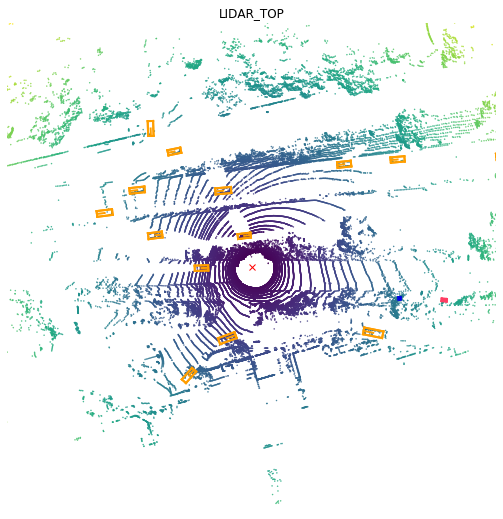

In [9]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
my_first_sample_token=my_scene["first_sample_token"]
visualize_lidar_of_sample(my_last_sample_token)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


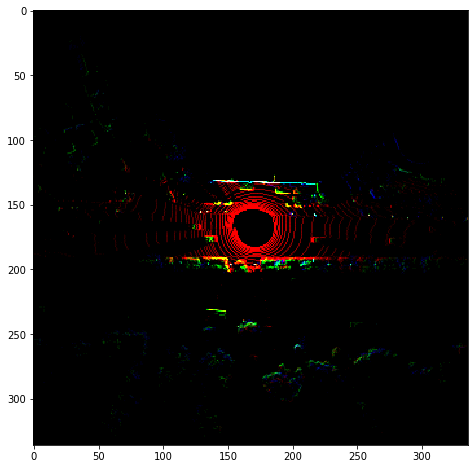

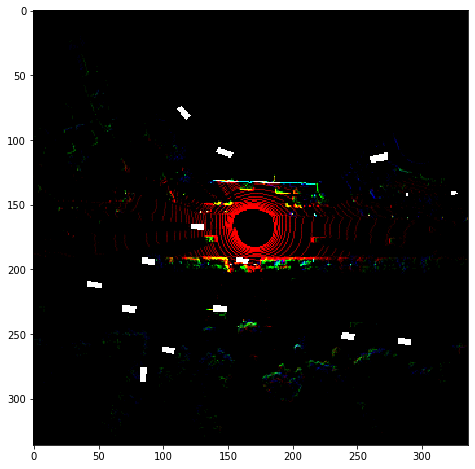

In [10]:
plt.figure(figsize=(16,8))
plt.imshow(bev)
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

sample = level5data.get("sample", my_last_sample_token)
sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
boxes = level5data.get_boxes(sample_lidar_token)
#print(boxes)
bev_helper.move_boxes_to_car_space(boxes, ego_pose)
bev_helper.scale_boxes(boxes, 0.8)
bev_helper.draw_boxes(bev, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow(bev, cmap='Set2')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False


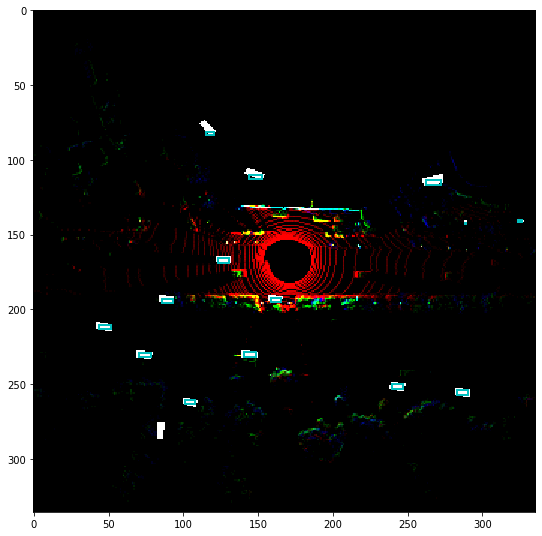

In [11]:
import matplotlib.patches as patches
corners_voxel_list=[]
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(bev)
bev_helper.scale_boxes(boxes, 0.8)
for box in boxes:   
    corners = box.bottom_corners()
    corners_voxel = bev_helper.car_to_voxel_coords(corners, [336,336,3], voxel_size, z_offset).transpose(1,0)
    corners_voxel = corners_voxel[:,:2] # Drop z coord
    corners_voxel_list.append(corners_voxel)
    rect= patches.Rectangle([corners_voxel[0][0],corners_voxel[1][1]],   corners_voxel[3][0]-corners_voxel[0][0], corners_voxel[0][1]-corners_voxel[1][1],linewidth=2,edgecolor="c", fill=False)
    ax.add_patch(rect)
print(boxes[0]==boxes_b[124][0])

In [12]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import regularizers, initializers

from utils import rpn_keras

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [13]:
from utils.rpn_keras import Config

base_path = 'G:/lyft/nuscenes-devkit/avod_lyft'
train_path =  'G:/lyft/nuscenes-devkit/avod_lyft/annotation.txt' # Training data (annotation file)

num_rois = 4 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training. 
vertical_flips = True   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model/model_frcnn_vgg.hdf5')
record_path = os.path.join(base_path, 'model/record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)
base_weight_path = os.path.join(base_path, 'model/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

# Create the config
C = Config()
C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90
C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois
C.base_net_weights = base_weight_path

In [ ]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = rpn_keras.get_data(train_path)
print(train_imgs[10])
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

In [ ]:
classes_count['bg'] = 0
class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
print(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C,config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

In [ ]:
from matplotlib import transforms
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))
    
    gt_x1, gt_x2 = image_data['bboxes'][7]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][7]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][7]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][7]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    print("gt",gt_x1, gt_y1, gt_x2, gt_y2)
    
    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    #cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    #cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    #cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#        cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()